In [11]:
import nibabel as nib
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import skimage

In [12]:
epi_img = nib.load('sub-001_brain.nii.gz')

In [13]:
epi_img_data = epi_img.get_fdata()
epi_img_data.shape

(208, 256, 256)

## Preview image processing

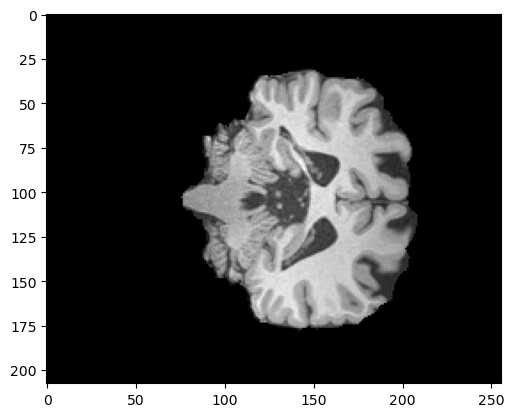

In [30]:
data = epi_img_data[:, 100, :]
min_val = np.min(data)
max_val = np.max(data)
if np.unique(data).size > 1:
    normalized_data = (data - min_val) / (max_val - min_val) * 256
plt.imshow(normalized_data, cmap='gray')
plt.show()

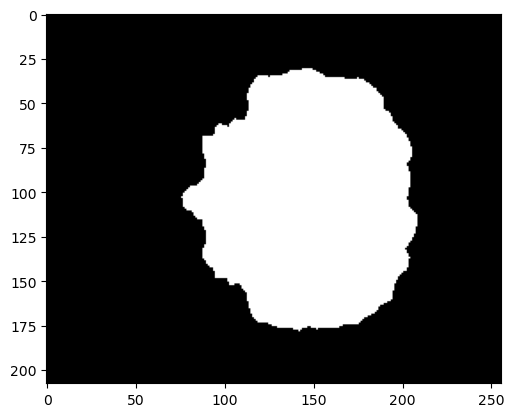

In [31]:
_, binary_image = cv.threshold(normalized_data, 1, 255, cv.THRESH_BINARY)
binary_image = binary_image > 0
plt.imshow(binary_image, cmap='gray')
plt.show()

In [32]:
structuring_element = np.array([
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]
    ], dtype=bool)

structuring_element_s = np.array([
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]
    ], dtype=bool)

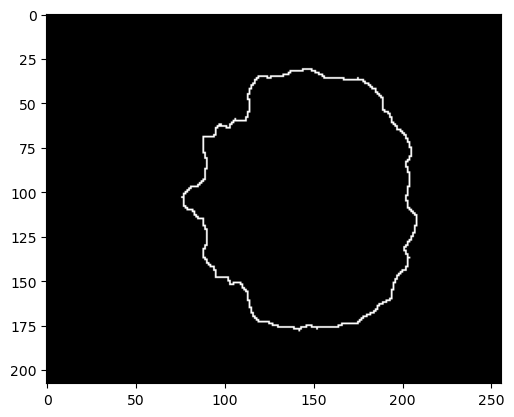

In [33]:
boundary = np.bitwise_xor(binary_image, skimage.morphology.binary_erosion(binary_image, structuring_element_s)) 
plt.imshow(boundary, cmap='gray')
plt.show()

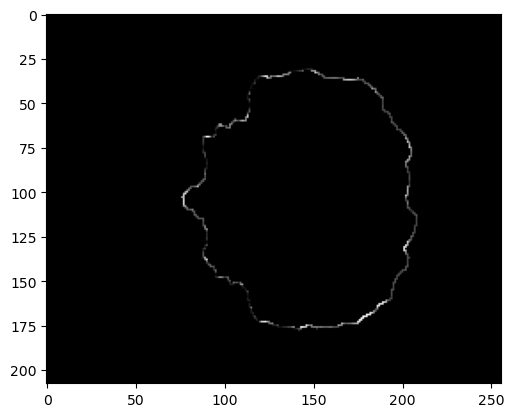

In [34]:
binary_mask = boundary.astype(data.dtype)
resulting_image = np.where(binary_mask, normalized_data, 0)

plt.imshow(resulting_image, cmap='gray')
plt.show()

## Brain construction functions

In [35]:
def create_point_cloud(image, z_value, threshold=5/255.0):
    height, width = image.shape
    x, y = np.meshgrid(np.arange(width), np.arange(height))  # Create a meshgrid of image coordinates
    z = np.full_like(x, z_value)  # Create a z-coordinate array with the given z_value
    
    # Flatten the arrays and stack them together
    points = np.stack((x.flatten(), y.flatten(), z.flatten()), axis=-1)
    colors = np.tile(image.flatten()[:, None], (1, 3))

    # Apply threshold to filter out points with a grayscale value of 5 or lower
    mask = image.flatten() > threshold
    points = points[mask]
    colors = colors[mask]
    
    return points, colors

In [36]:
points = np.empty((0, 3))
colors = np.empty((0, 3))

for i in range(epi_img_data.shape[0]):
    data = epi_img_data[:, i, :]
    min_val = np.min(data)
    max_val = np.max(data)
    if np.unique(data).size > 1:
        normalized_data = (data - min_val) / (max_val - min_val) * 256
    else:
        normalized_data = data
    _, binary_image = cv.threshold(normalized_data, 5, 255, cv.THRESH_BINARY)
    binary_image = binary_image > 0
    boundary = np.bitwise_xor(binary_image, skimage.morphology.binary_erosion(binary_image, structuring_element_s)) 
    binary_mask = boundary.astype(data.dtype)
    resulting_image = np.where(binary_mask, normalized_data, 0)
    resulting_image = resulting_image / 255.0
    
    point, color = create_point_cloud(resulting_image, i, 5 / 255.0)
    points = np.concatenate((points, point))
    colors = np.concatenate((colors, color))

In [37]:
# Create the Open3D point cloud object
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors)
print(pcd)
o3d.visualization.draw_geometries([pcd])

PointCloud with 79070 points.


In [38]:
np.save('constructions/sub-001_points.npy', points)
np.save('constructions/sub-001_colors.npy', colors)
o3d.io.write_point_cloud('constructions/sub-001.ply', pcd)

[Open3D WARNING] Write Ply clamped color value to valid range


True

## Surface Reconstruction

In [39]:
pcd.estimate_normals()

In [40]:
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        pcd, depth=9)

[Open3D DEBUG] Input Points / Samples: 79070 / 79070
[Open3D DEBUG] #   Got kernel density: 0.16553902626037598 (s), 534.17578125 (MB) / 534.17578125 (MB) / 641 (MB)
[Open3D DEBUG] #     Got normal field: 0.2931210994720459 (s), 570.67578125 (MB) / 570.67578125 (MB) / 641 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 4.590475e-05 / 3.629689e+00
[Open3D DEBUG] #       Finalized tree: 0.4271969795227051 (s), 621.92578125 (MB) / 621.92578125 (MB) / 641 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.7143468856811523 (s), 609.328125 (MB) / 621.92578125 (MB) / 641 (MB)
[Open3D DEBUG] #Set point constraints: 0.1142129898071289 (s), 609.328125 (MB) / 621.92578125 (MB) / 641 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 1627858 / 1214808 / 645601
[Open3D DEBUG] Memory Usage: 609.328 MB
Cycle[0] Depth[0/9]:	Updated constraints / Got system / Solved in:  0.000 /  0.000 /  0.000	(609.328 MB)	Nodes: 8
CG: 1.7779e+00 -> 1.7779e+00 -> 1.0627e-03 (6.0e-04) [32605]
[Open3D DEBUG] # L

In [41]:
mesh

TriangleMesh with 246883 points and 495036 triangles.

In [42]:
o3d.visualization.draw_geometries([mesh])